<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/GoingDeeper/GoingDeeper_NLP12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 멋진 챗봇 만들기

In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import random
import math
import gensim
from tqdm import tqdm
from tqdm import tqdm_notebook
from konlpy.tag import Mecab
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. 데이터 불러오기

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Colab/Datasets/Chatbot_data-master/ChatbotData.csv')
print(data.shape)
data.head()

(11823, 3)


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
questions = data.Q
answers = data.A

전처리

In [4]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)

    sentence = sentence.strip()
    
    return sentence

토큰화  

아래 조건을 만족하는 build_corpus() 함수를 구현하세요!

1. 소스 문장 데이터와 타겟 문장 데이터를 입력으로 받습니다.  
2. 데이터를 앞서 정의한 preprocess_sentence() 함수로 정제하고, 토큰화합니다.
3. 토큰화는 전달받은 토크나이즈 함수를 사용합니다. 이번엔 mecab.morphs 함수를 전달하시면 됩니다.
4. 토큰의 개수가 일정 길이 이상인 문장은 데이터에서 제외합니다.
5. 중복되는 문장은 데이터에서 제외합니다. 소스 : 타겟 쌍을 비교하지 않고 소스는 소스대로 타겟은 타겟대로 검사합니다. 중복 쌍이 흐트러지지 않도록 유의하세요!

In [5]:
raw = zip(questions, answers)
cleaned_corpus = set(raw)
len(cleaned_corpus)

11750

In [6]:
cleaned_questions, cleaned_answers = zip(*cleaned_corpus)

In [7]:
def build_corpus(src, tgt):
    mecab = Mecab()

    src_cor = []
    tgt_cor = []
    
    for s, t in zip(src, tgt):
        if len(s) <= 30:
            src_cor.append(mecab.morphs(preprocess_sentence(s)))
            tgt_cor.append(mecab.morphs(preprocess_sentence(t)))
    
    
    return src_cor, tgt_cor

que_corpus, ans_corpus = build_corpus(cleaned_questions, cleaned_answers)

In [8]:
print(len(que_corpus), len(ans_corpus))

11577 11577


## 2. Data Argumentation

Word2Vec를 이용한 Data Argumentation

In [9]:
model = gensim.models.Word2Vec.load('/content/drive/MyDrive/Colab/Datasets/word2vec/ko.bin')

In [10]:
model.most_similar('바나나')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('코코넛', 0.8097119927406311),
 ('시금치', 0.7701147794723511),
 ('레몬', 0.76884925365448),
 ('땅콩', 0.7684735059738159),
 ('파인애플', 0.7639915347099304),
 ('녹차', 0.7631460428237915),
 ('딸기', 0.7617197036743164),
 ('바닐라', 0.7497864961624146),
 ('파슬리', 0.7447543144226074),
 ('코코아', 0.7408244609832764)]

In [11]:
def lexical_sub(sentence, word2vec):
    res = ""
    toks = sentence

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]
        
    except:   # 단어장에 없는 단어
        return None

    for tok in toks:
        if tok is _from: res += _to + " "
        else: res += tok + " "

    return res

In [12]:
new_que_corpus = []

for old_src in tqdm(que_corpus):
    new_src = lexical_sub(old_src, model)
    if new_src is not None:
        new_que_corpus.append(new_src)
    else:
        new_que_corpus.append(old_src)

print(len(que_corpus))
print(len(new_que_corpus))

  0%|          | 0/11577 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys
100%|██████████| 11577/11577 [00:16<00:00, 690.93it/s]

11577
11577


In [13]:
new_ans_corpus = []

for old_src in tqdm(ans_corpus):
    new_src = lexical_sub(old_src, model)
    if new_src is not None:
        new_ans_corpus.append(new_src)
    else:
        new_ans_corpus.append(old_src)

print(len(ans_corpus))
print(len(new_ans_corpus))

  0%|          | 0/11577 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys
100%|██████████| 11577/11577 [00:16<00:00, 719.87it/s]

11577
11577


Augmentation된 que_corpus 와 원본 ans_corpus 가 병렬을 이루도록, 이후엔 반대로 원본 que_corpus 와 Augmentation된 ans_corpus 가 병렬을 이루도록 하여 전체 데이터가 원래의 3배가량으로 늘어나도록 합니다.

In [14]:
arg_que = que_corpus + new_que_corpus + que_corpus
arg_ans = ans_corpus + new_ans_corpus + ans_corpus

In [15]:
for i in range(len(arg_ans)):
    arg_ans[i] = ["<start>"] + list(arg_ans[i]) + ["<end>"]

In [16]:
arg_ans[:3]

[['<start>', '폰', '요금', '절약', '되', '겠', '네요', '.', '<end>'],
 ['<start>', '저', '는', '위기', '조', '차', '없', '네요', '.', '<end>'],
 ['<start>', '선', '이', '예뻐질', '거', '예요', '.', '<end>']]

In [17]:
print(len(arg_que))
print(len(arg_ans))

34731
34731


In [18]:
corpus = arg_que + arg_ans

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

tokenizer.fit_on_texts(corpus)


enc_train = tokenizer.texts_to_sequences(arg_que)
enc_train = pad_sequences(enc_train, padding='post')

dec_train = tokenizer.texts_to_sequences(arg_ans)
dec_train = pad_sequences(dec_train, padding='post')

In [19]:
VOCAB_SIZE = len(tokenizer.index_word)
VOCAB_SIZE

7913

## 3. Transformer 모델 생성

In [20]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [21]:
# Mask  생성하기
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)
    
    return enc_mask, dec_enc_mask, dec_mask

In [22]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        return out, attentions
        
    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])
        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))
        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
        return out, attention_weights

In [23]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        return out

In [24]:
# Encoder의 레이어 구현
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [25]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):

        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [26]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

            
        return out, enc_attns

In [27]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

            
        return out, dec_attns, dec_enc_attns

In [28]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        
        return out

    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [118]:
transformer = Transformer(
    n_layers=1,
    d_model=128,
    n_heads=16,
    d_ff=2048,
    src_vocab_size=20000,
    tgt_vocab_size=20000,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 256

In [119]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=1000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [120]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)
                                        

In [121]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [122]:
# Train Step 정의
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]  # Decoder의 input
    gold = tgt[:, 1:]     # Decoder의 output과 비교하기 위해 right shift를 통해 생성한 최종 타겟

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))   

    return loss, enc_attns, dec_attns, dec_enc_attns

In [124]:
# 훈련시키기
BATCH_SIZE = 64
EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    np.random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                   dec_train[idx:idx+BATCH_SIZE],
                   transformer,
                   optimizer)
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch  5: 100%|██████████| 543/543 [00:44<00:00, 12.30it/s, Loss 0.8343]


In [47]:
def get_decoded_sentence(sentence):
            return ' '.join([tokenizer.index_word[index] for index in sentence])

def evaluate(sentence, model):

    mecab = Mecab()

    sentence = preprocess_sentence(sentence)
    pieces = mecab.morphs(sentence)
    tokens = tokenizer.texts_to_sequences(pieces)
    _input = pad_sequences(tokens, maxlen=enc_train.shape[-1], padding='post')
    
    ids = [] 
    output = tf.expand_dims([3], 0) 
    
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
                
        if 4 == predicted_id:
            result = get_decoded_sentence(ids)           
            return pieces, result, enc_attns, dec_attns, dec_enc_attns
        
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

def generate(sentence, model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model)
    
    print('\nInput: %s' % (sentence))
    print('Answer: {}'.format(result))

    return result

In [125]:
generate('지루하다, 놀러가고 싶어.', transformer)
generate('오늘 일찍 일어났더니 피곤하다.', transformer)
generate('간만에 여자친구랑 데이트 하기로 했어.', transformer)
generate('집에 있는다는 소리야.', transformer)


Input: 지루하다, 놀러가고 싶어.
Predicted translation: 잠 시   이   라 도   마 음   이   라 가   는   건   어 떨 까   요   .  

Input: 오늘 일찍 일어났더니 피곤하다.
Predicted translation: 오늘 밖 에 감사 잘 생겼 을 가져 보 세요 .

Input: 간만에 여자친구랑 데이트 하기로 했어.
Predicted translation: 떨리 죠 .

Input: 집에 있는다는 소리야.
Predicted translation: 맘 결정 이 있 었 결정 되 었 나 봐요 .


'맘 결정 이 있 었 결정 되 었 나 봐요 .'

In [ ]:
transformer = Transformer(
    n_layers=1,
    d_model=256,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=20000,
    tgt_vocab_size=20000,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 256

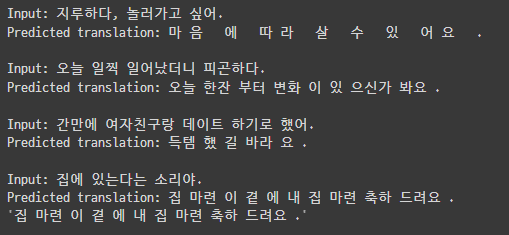

In [ ]:
transformer = Transformer(
    n_layers=1,
    d_model=256,
    n_heads=16,
    d_ff=1024,
    src_vocab_size=20000,
    tgt_vocab_size=20000,
    pos_len=200,
    dropout=0.2,
    shared_fc=True,
    shared_emb=True)

d_model = 256

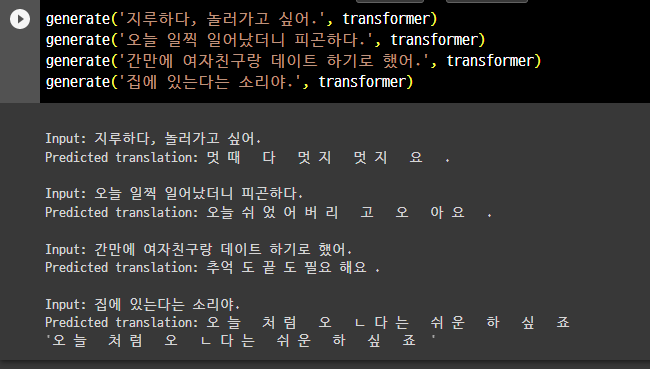

In [ ]:
transformer = Transformer(
    n_layers=1,
    d_model=128,
    n_heads=8,
    d_ff=1024,
    src_vocab_size=20000,
    tgt_vocab_size=20000,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 256

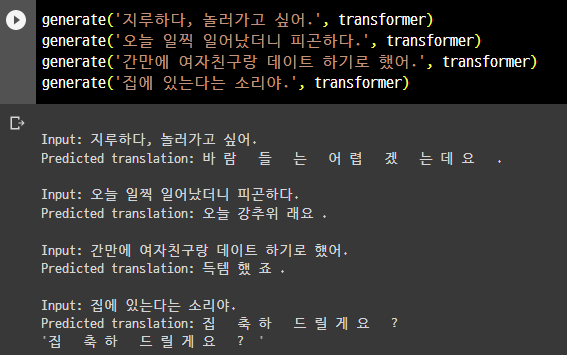

In [ ]:
transformer = Transformer(
    n_layers=1,
    d_model=512,
    n_heads=4,
    d_ff=1024,
    src_vocab_size=20000,
    tgt_vocab_size=20000,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 512

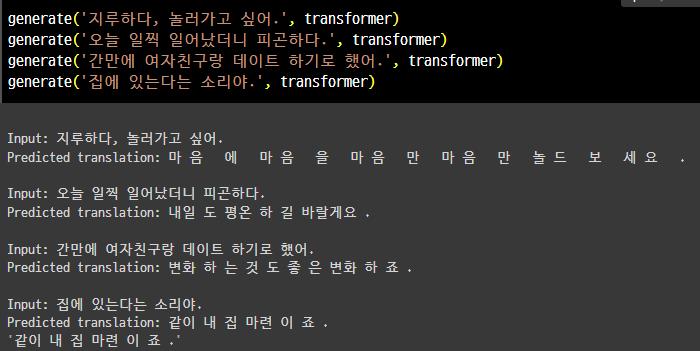

In [ ]:
transformer = Transformer(
    n_layers=1,
    d_model=128,
    n_heads=16,
    d_ff=2048,
    src_vocab_size=20000,
    tgt_vocab_size=20000,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 256

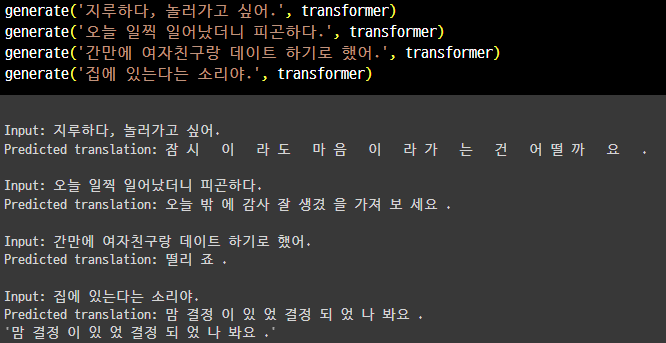

마지막을 제외하고는 전부 10에폭 학습시켰고 마지막은 5에폭 학습시켰다.  
마지막의 예제 결과가 마음에 들어서 마지막 걸로 챗봇을 테스트 해보려고 한다.

## 4. BLEU 측정

In [128]:
reference = '밥 뭐먹을까?'
candidate = generate(reference, transformer)


Input: 밥 뭐먹을까?
Predicted translation: 밥 은 비싸 겠 어요 .


In [129]:
print("원문:", reference)
print("번역문:", candidate)
print("BLEU Score:", sentence_bleu([reference], candidate))

원문: 밥 뭐먹을까?
번역문: 밥 은 비싸 겠 어요 .
BLEU Score: 5.019362538473707e-155


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [130]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference],
                         candidate,
                         weights=weights,
                         smoothing_function=SmoothingFunction().method1)  # smoothing_function 적용

print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

BLEU-1: 0.15384615384615385
BLEU-2: 0.08333333333333333
BLEU-3: 0.009090909090909096
BLEU-4: 0.010000000000000004

BLEU-Total: 0.03285702044797773


In [131]:
reference = '이제 뭐하지?'
candidate = generate(reference, transformer)


Input: 이제 뭐하지?
Predicted translation: 이젠 잊어버리 세요 .


In [132]:
print("BLEU-1:", calculate_bleu(reference, candidate, weights=[1, 0, 0, 0]))
print("BLEU-2:", calculate_bleu(reference, candidate, weights=[0, 1, 0, 0]))
print("BLEU-3:", calculate_bleu(reference, candidate, weights=[0, 0, 1, 0]))
print("BLEU-4:", calculate_bleu(reference, candidate, weights=[0, 0, 0, 1]))

print("\nBLEU-Total:", calculate_bleu(reference, candidate))

BLEU-1: 0.16666666666666669
BLEU-2: 0.009090909090909096
BLEU-3: 0.010000000000000004
BLEU-4: 0.011111111111111112

BLEU-Total: 0.020255986027125642


꽤나 말이 되는 답변이라고 생각되는데 BLEU점수는 0.02~0.03이 나온다.

## 5. 회고
1. 어려웠지만 그래도 실습했던거 열심히 따라하다 보니 끝까지 할 수 있었다. 
2. VOCAB_SIZE를 딱 토크나이저에 맞게 하니까 loss가 Nan이 되면서 계속 학습이 안되더라.. 이유는 모르겠지만 예전에 한대로 2만으로 늘렸더니 정상적으로 학습되는 모습을 볼 수 있었다. 
3. BLEU점수는 일단 번역기에 대한 성능이고 이건 챗봇이니까 그래도 사람이 이해할만한 답변만 뱉어냈다면 괜찮은 성능인 것이 아닐까 하는 생각이 들었다. 